In [11]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
import os
from model.pipeline import build_feature_matrix_and_target
from data_processing.split import split_member_time
from model.ednn_model import ednn_regressor_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#---------------- Build the full feature & target arrays
X, y = build_feature_matrix_and_target()

#---------------- Split & scale (returns 8 objects)
(
    X_train_xr, X_val_xr,
    y_train_xr, y_val_xr,
    X_train,    X_val,
    y_train,    y_val
) = split_member_time(X, y)

#---------------- Sanity‐check shapes
print("Full X, y shapes:         ", X.shape, y.shape)
print("X_train_xr, X_val_xr:     ", X_train_xr.shape, X_val_xr.shape)
print("X_train, X_val:           ", X_train.shape, X_val.shape)
print("y_train_xr, y_val_xr:     ", y_train_xr.shape, y_val_xr.shape)
print("y_train, y_val:           ", y_train.shape, y_val.shape)

Full X, y shapes:          (19836000, 37) (19836000,)
X_train_xr, X_val_xr:      (13780800, 37) (522000, 37)
X_train, X_val:            (13780800, 37) (522000, 37)
y_train_xr, y_val_xr:      (13780800,) (522000,)
y_train, y_val:            (13780800, 1) (522000, 1)


In [5]:
model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
#---------- Train  Annual Model
model_path = model_folder+"/ednn_reg_model.keras"

p_wu_val, p_wo_val, p_wu_train, p_wo_train, model, hist = ednn_regressor_model(
    X_train, y_train,
    X_val, y_val,
    model_path=model_path,#"ednn_best.keras",
    hidden_layers=4,
    hidden_neurons=64,#32,
    activation='leaky_relu',#'leaky_relu'
    l2_weight=0.00071073,
    dropout_alpha=0.1,
    use_dropout=False,
    use_noise=False,
    noise_sd=0.1,
    loss_weight=1e-10,#8
    learning_rate=0.00018102,
    batch_size=1200,
    epochs=50,
    patience=140,
)

Epoch 1/2

Epoch 1: val_loss improved from inf to 1.22366, saving model to /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model/ednn_reg_model.keras
11484/11484 - 30s - 3ms/step - loss: 1.0880 - mse: 2.7662 - val_loss: 1.2237 - val_mse: 2.4982 - learning_rate: 0.0010
Epoch 2/2

Epoch 2: val_loss improved from 1.22366 to 1.19549, saving model to /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model/ednn_reg_model.keras
11484/11484 - 29s - 3ms/step - loss: 1.0037 - mse: 3.6457 - val_loss: 1.1955 - val_mse: 3.2178 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
13781/13781 ━━━━━━━━━━━━━━━━━━━━ 13s 929us/step
13781/13781 ━━━━━━━━━━━━━━━━━━━━ 13s 913us/step


In [9]:
def plot_training_history(history, save_paths=None, figsize=(8, 5)):
    """
    Plot training mean squared error (MSE) and loss over epochs.

    Args:
        history: Keras History object returned by model.fit().
        save_paths: Optional dict with keys 'mse' and 'loss' mapping to file paths
                    to save the respective figures. If None, figures are not saved.
        figsize: Tuple specifying figure size.
    """
    #------------- Extract epoch indices
    epochs = history.epoch
    #------------- Extract metric values
    train_mse = history.history.get('mse', [])
    val_loss = history.history.get('loss', [])

    #------------- Plot Mean Squared Error over epochs
    plt.figure(figsize=figsize)
    plt.plot(
        epochs,
        train_mse,
        label='Train MSE',
        marker='o',
        linestyle='--',
        linewidth=2
    )
    plt.title('ANN Training: Mean Squared Error', fontsize=13)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Mean Squared Error', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(shadow=True, edgecolor='black')
    if save_paths and 'mse' in save_paths:
        plt.savefig(save_paths['mse'], bbox_inches='tight')
    plt.show()

    #------------- Plot Loss over epochs
    plt.figure(figsize=figsize)
    plt.plot(
        epochs,
        val_loss,
        label='Validation Loss',
        marker='o',
        linestyle='-',
        linewidth=2
    )
    plt.title('ANN Training: Loss', fontsize=13)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(shadow=True, edgecolor='black')
    if save_paths and 'loss' in save_paths:
        plt.savefig(save_paths['loss'], bbox_inches='tight')
    plt.show()

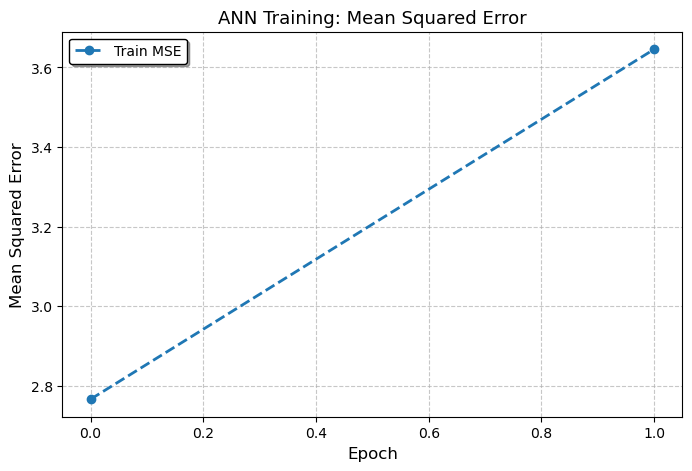

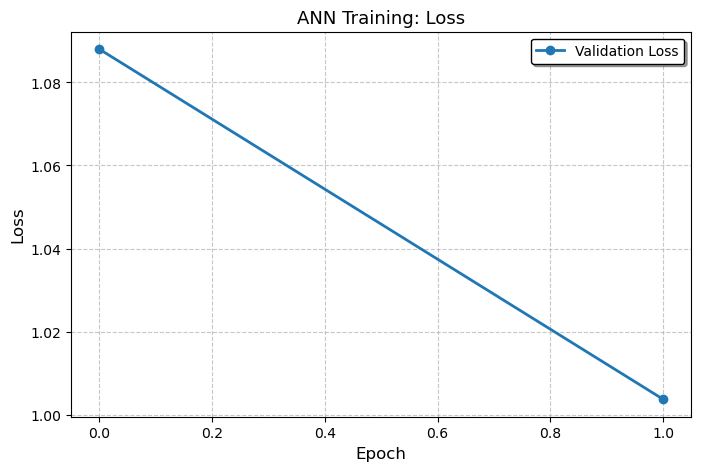

In [10]:
plot_training_history(hist, save_paths={'mse': 'mse.png', 'loss': 'loss.png'})